# 1996 Census Data - An In-Depth Look

![alt text](http://www.radiotnn.com/wp-content/uploads/2015/03/morocco-census-2014-population.jpg 'title')

### Table of Contents ###
> **Part 1: [SQL & Export to .CSV](#1)**
 
> **Part 2: [Import .CSV](#2)**

> **Part 3: [Exploratory Analysis](#3)**
 * [Categorical Variables](#3a)
 * [Continuous Variables](#3b)

> **Part 4: [Comparison of Over 50k and Under 50k](#4)**
 * [Distributions Overlayed](#4a)
 * [Impact of Employer, Education, Marriage](#4b)
 
> **Part 5: [Model Building](Part 2. Model Building.ipynb)** 

## <a id="1"></a>Part 1. SQL & Export to .CSV

In [198]:
import sqlite3
import csv

sqlite_file = 'exercise01.sqlite'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

In [199]:
sql = """
SELECT records.id, 
age,  
workclasses.name as workclass, 
education_levels.name as education_level,
education_num,
marital_statuses.name as marital_status, 
occupations.name as occupations,
relationships.name as relationships,
races.name as race, 
sexes.name as sex, 
countries.name as country, 
capital_gain, 
capital_loss, 
hours_week,
over_50k 

FROM records, workclasses, marital_statuses, occupations, races, sexes, countries, education_levels, relationships

WHERE records.workclass_id = workclasses.id
and records.education_level_id = education_levels.id
and records.marital_status_id = marital_statuses.id 
and records.occupation_id = occupations.id
and records.relationship_id = relationships.id
and records.race_id = races.id
and records.sex_id = sexes.id
and records.country_id = countries.id;
"""
data = c.execute(sql)
#print c.fetchall()

In [200]:
col_name_list = [tuple[0] for tuple in c.description]
col_name_list

['id',
 'age',
 'workclass',
 'education_level',
 'education_num',
 'marital_status',
 'occupations',
 'relationships',
 'race',
 'sex',
 'country',
 'capital_gain',
 'capital_loss',
 'hours_week',
 'over_50k']

In [201]:
# write to a csv file, where the first row is the names of the column
with open("output.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(col_name_list)
    writer.writerows(data)

## <a id="2"></a>Part 2. Import CSV

In [322]:
import pandas as pd
data = pd.read_csv("output.csv")
data.head()

,id,age,workclass,education_level,education_num,marital_status,occupations,relationships,race,sex,country,capital_gain,capital_loss,hours_week,over_50k
0,1,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,2174,0,40,0
1,2,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,0,0,13,0
2,3,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,0,0,40,0
3,4,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,0,0,40,0
4,5,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,0,0,40,0


In [324]:
data.shape

(48842, 15)

In [323]:
data.dtypes

id                  int64
age                 int64
workclass          object
education_level    object
education_num       int64
marital_status     object
occupations        object
relationships      object
race               object
sex                object
country            object
capital_gain        int64
capital_loss        int64
hours_week          int64
over_50k            int64
dtype: object

In [325]:
# rearranged the columns to show all categorical first, then show all continuous
data = data[['id', 'sex', 'race', 'workclass', 'occupations', 'education_level', 'marital_status', 'relationships', 'country', 'age', 'education_num', 'capital_gain', 'capital_loss', 'hours_week', 'over_50k']]

## <a id="3"></a>Part 3. Exploratory Analysis on Categorical Variables

In [263]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

### <a id="3a"></a>3a. Categorical Variables
The first thing to explore is the distribution of our variables. We will first explore the distribution of categorical variables.

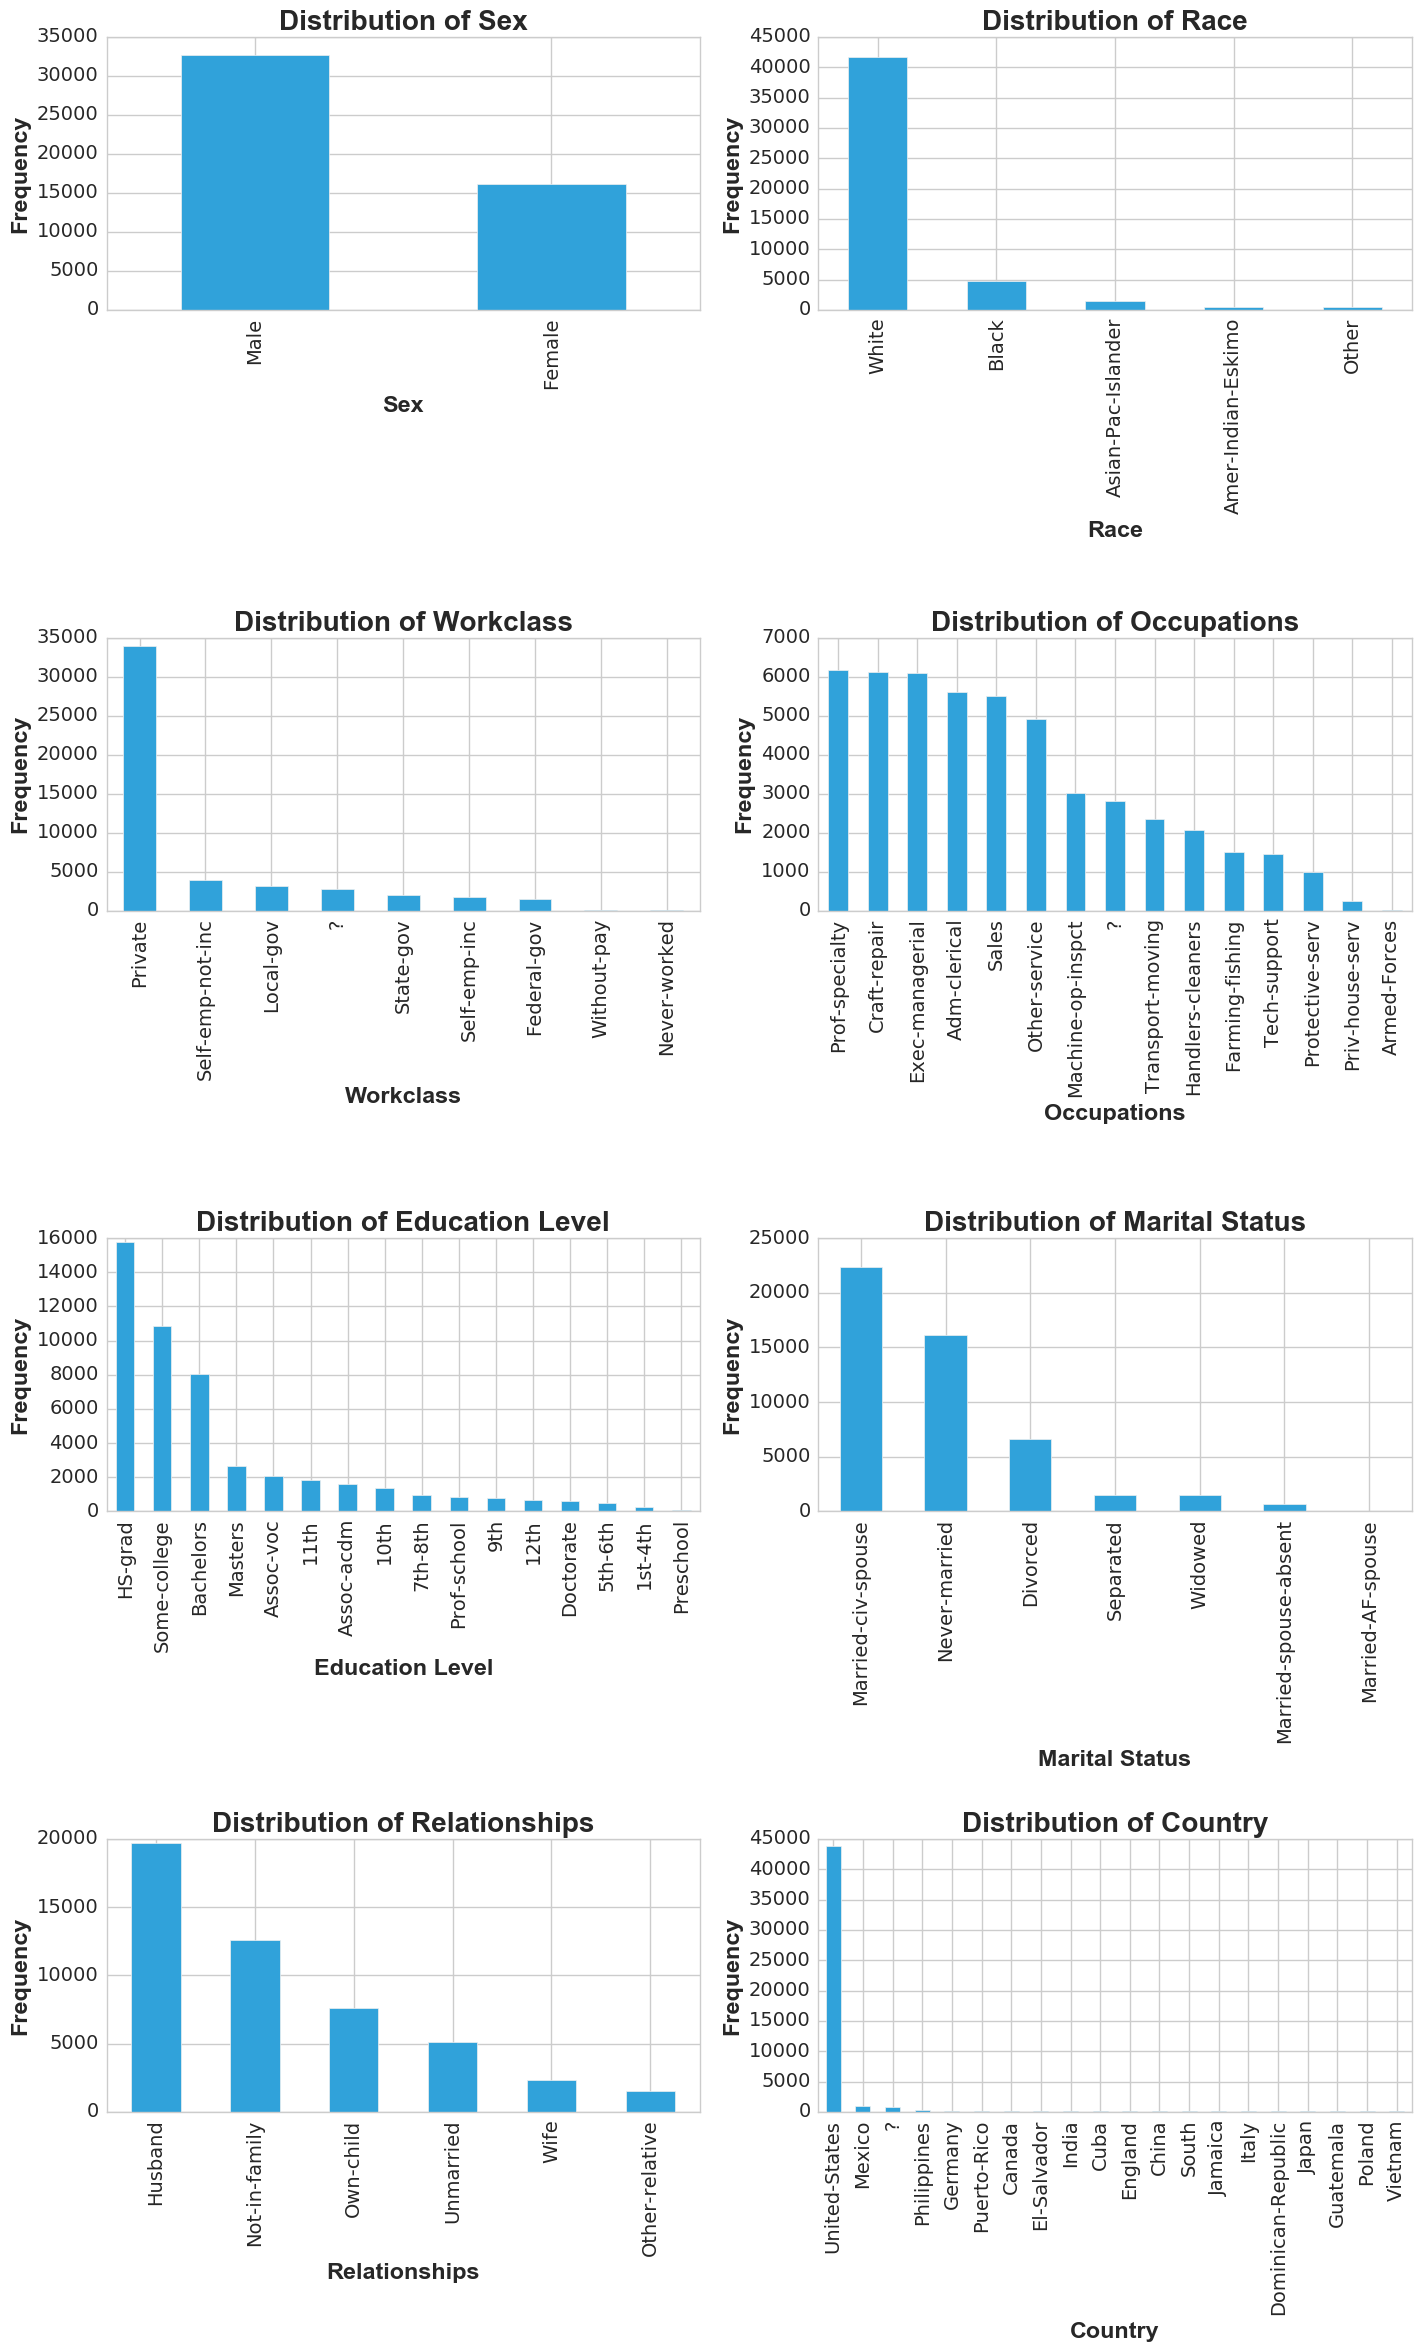

In [350]:
categoricals = [col for col in data.columns if data[col].dtype.name == 'object']

fig, axes = plt.subplots(nrows=len(categoricals) / int(2), ncols=2)
fig.subplots_adjust(hspace=1.2)
j = 0

for index, column in enumerate(categoricals):
    grouped = data.groupby(column)[column].count().sort_values(ascending = False).head(20)
    ax = grouped.plot(kind = 'bar', rot = 90, ax = axes[index / 2, j], figsize = (15, 25))
    
    ax.set_title('Distribution of {}'.format(column.title().replace('_', ' ')))
    ax.set_xlabel('{}'.format(column.title().replace('_', ' ')))
    ax.set_ylabel('Frequency')
        
    # alternate j between 0 and 1
    j = 1 - j 

**Sex**: More than two thirds of those surveyed are males. Are males more likely to respond to the census? Is there a bias in the census? There seems to be an overrepresentation of males in the census.

**Race**: The large majority of the surveyed poplulation is white. [Only 27.4% of the U.S. population was White in 1996](https://www.census.gov/prod/3/98pubs/p23-194.pdf), according to the official census. The white population is over-represented in this census. There must be some sampling bias. 

**Workclass**: Most people work in the private sector. Then, there is a sharp drop off. Most people who are not self-employed work for the government. There are more government employees at the local level than the state, and more at the state level than at the federal level.  

**Occupations**: People are hesitant to answer their occupation in surveys - hence the large frequency of '?'. There was a surprisingly large proportion of Executive/Managers, and low representation of *blue collar* jobs such as farming, transportation, or manual labor jobs.

**Education Level**: Most people are high school graduates or have some college. After a Bachelors degree, there is a sharp dropoff in number of people pursuing higher degrees - Master's and Doctorates.  High school graduates were about 33.6% of the population, according to the 1996 survey. 

**Marital Status**: The number of people married and in civil union almost equal those who have never married or were divorced. 

**Relationships**: As more than two thirds of those surveyed are males, there are many more husbands than wives.Otherwise, the next largest population is not in a family, followed by those who own a child, and unmarried.

**Country**: The overwhelming majority of people surveyed are from the United States - this feature may not be informative, as there is so little variance. 

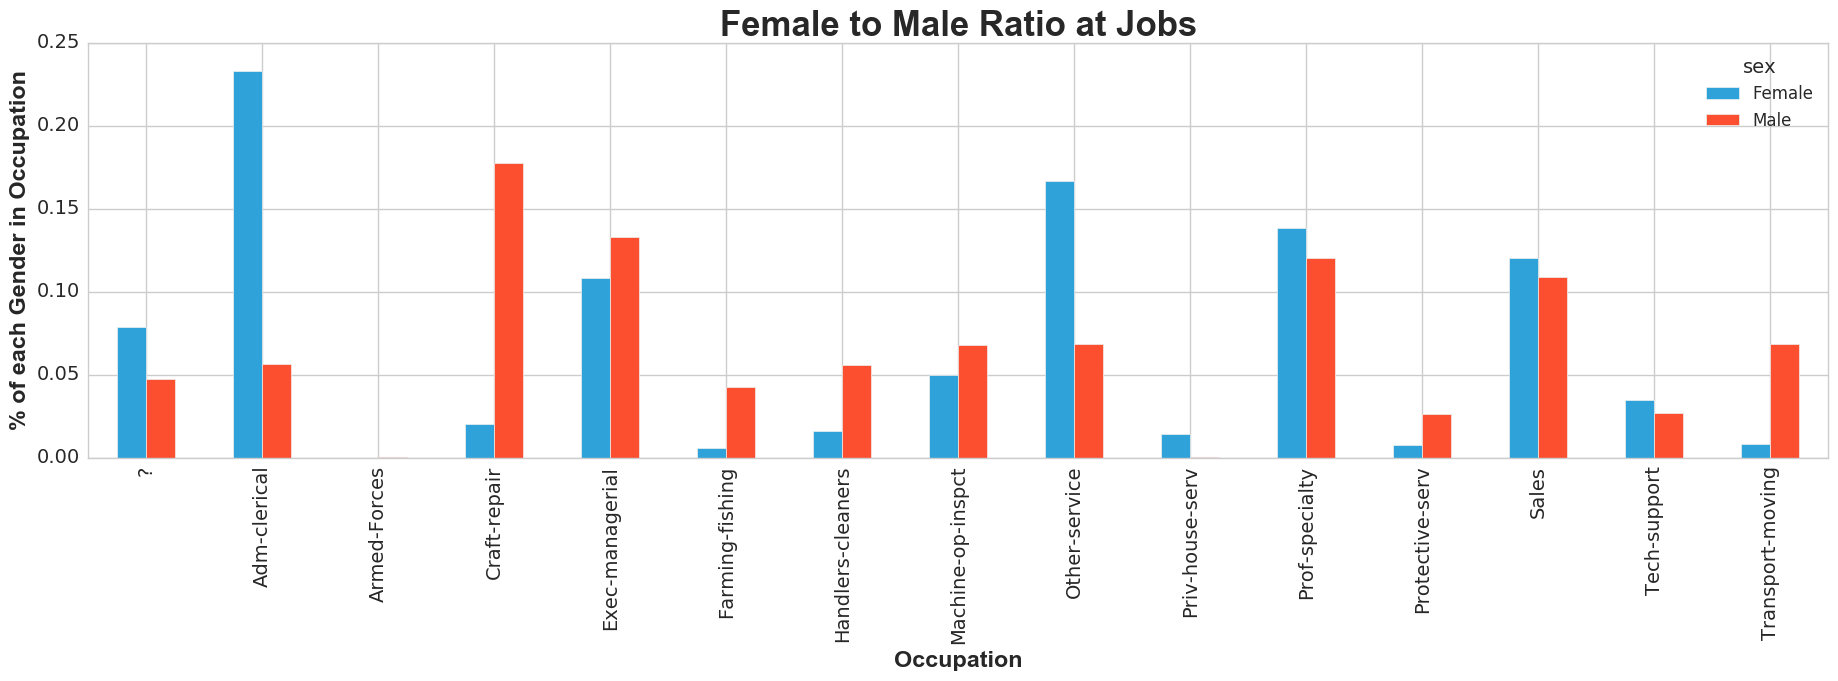

In [542]:
pd.crosstab(index=data['occupations'],  columns=data["sex"]).apply(lambda r: r/r.sum(), axis=0).plot(kind = 'bar', figsize = (20,5));
plt.title('Female to Male Ratio at Jobs', fontsize = 25, weight = 'bold');
plt.xlabel('Occupation'); 
plt.ylabel('% of each Gender in Occupation');

The largest disparity in percentage of male : female occured in jobs that involve a lot of physical activity. Women were very unlikely to partake in occupations like craft-repairs, transportation, protective services, and farming-fishing. The jobs most popular to women were Administrator-clerical, Professional-specialty, Sales, and Other-services, which were mostly in the service industry or involving interpersonal communication.  

I did not observe the male : female ratio in jobs because there is an inbalanced number of males (67%) in the data. Naturally, most jobs would show higher counts for males, because they are overrepresented in the census.

### 3b. Continuous Variables
We next look at our continuous variables. I layed out the plots of distribution in a similar tile-manner.

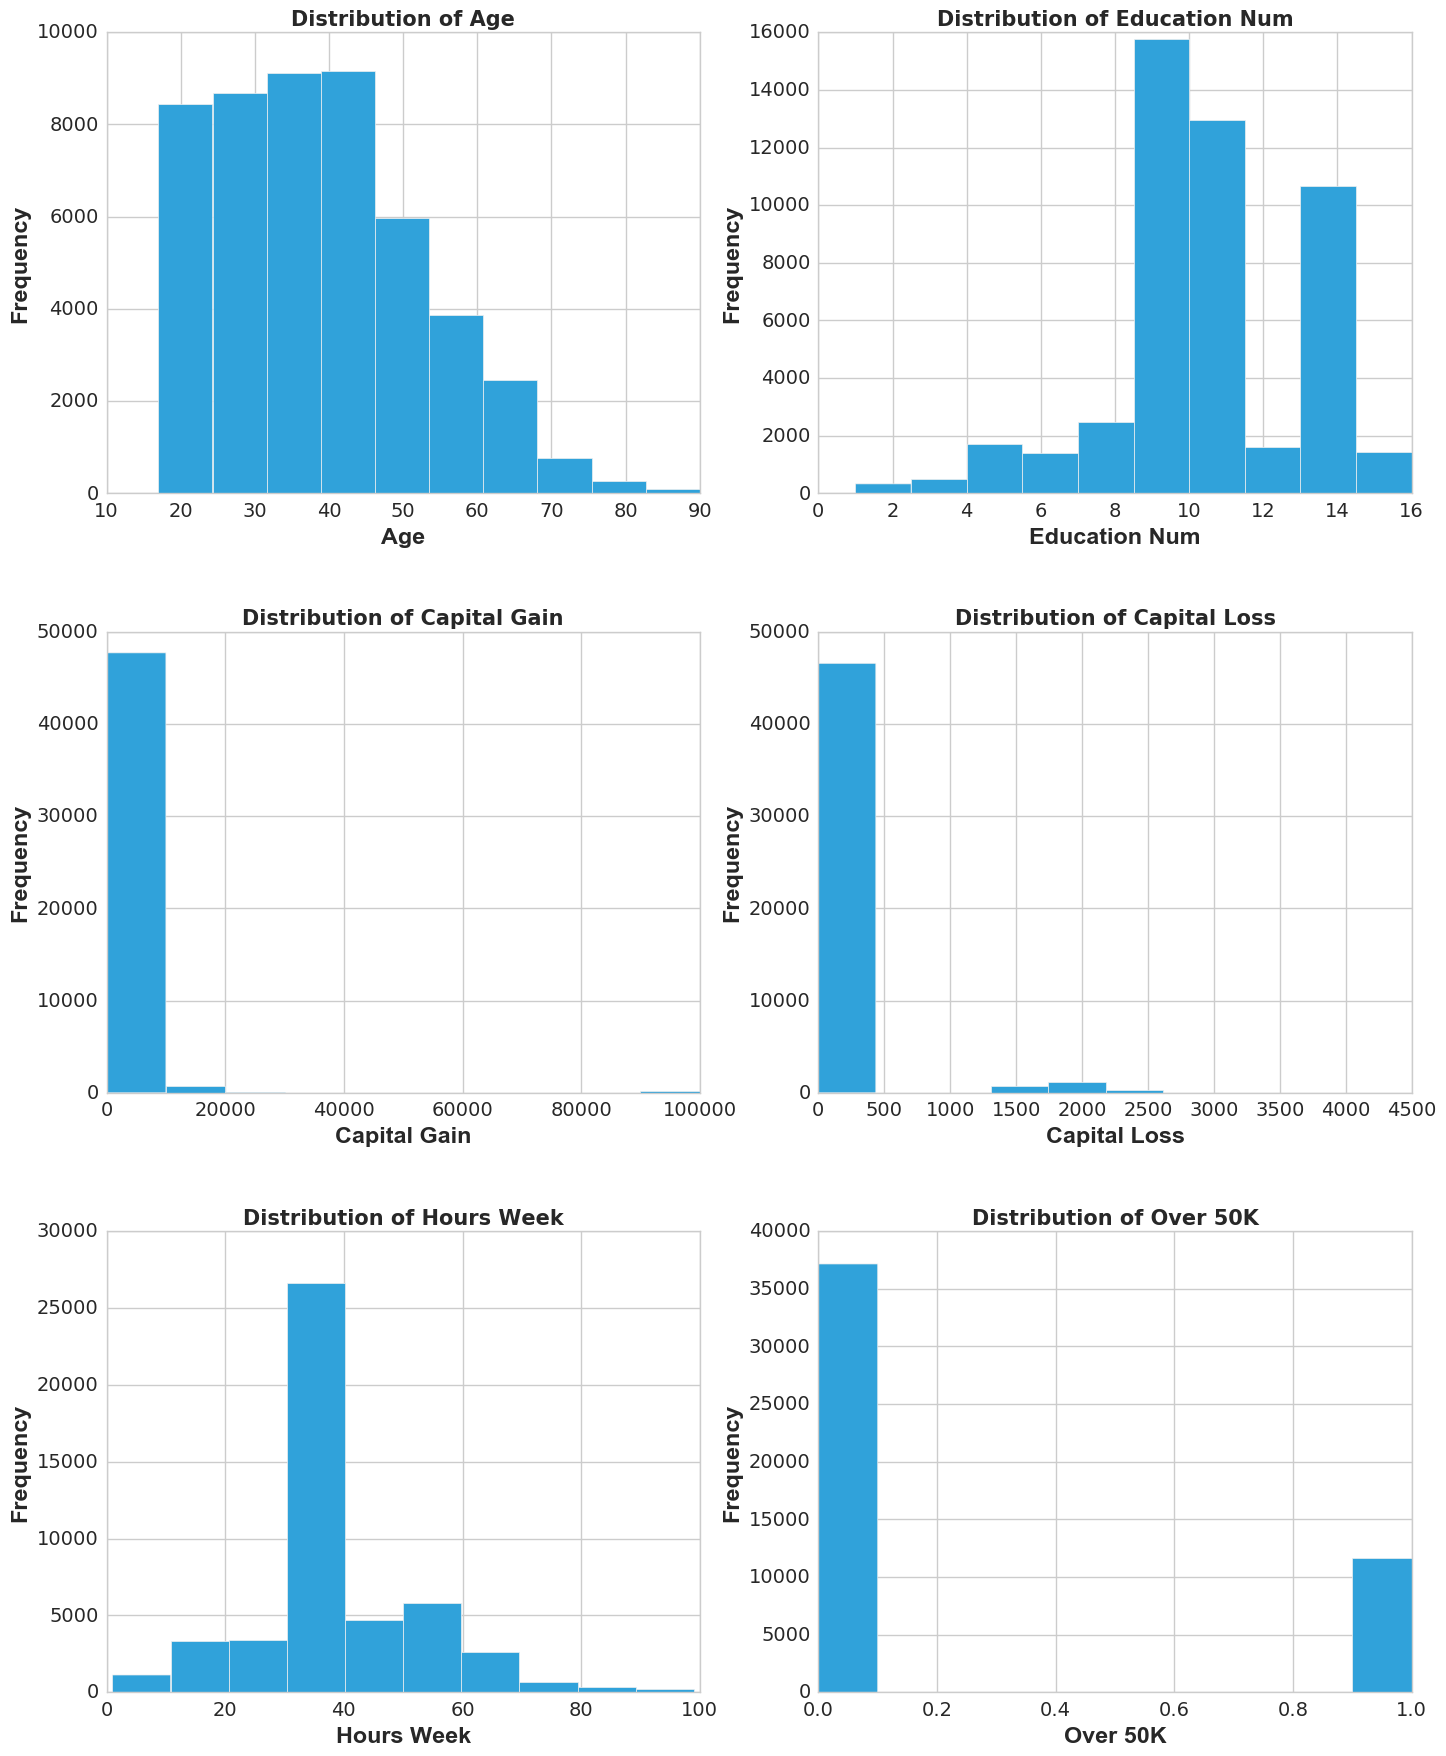

In [346]:
# all continuous variables not named 'id'
continuous = [col for col in data.columns if col != 'id' and data[col].dtype.name == 'int64']

fig, axes = plt.subplots(nrows = len(continuous) / int(2), ncols=2)
fig.subplots_adjust(hspace=.3)
j = 0

for index, column in enumerate(continuous):
    ax = data[column].plot(kind = 'hist', ax = axes[index / 2, j], figsize = (15, 20))
    ax.set_title('Distribution of {}'.format(column.title().replace('_', ' ')), weight = 'bold', fontsize = 15)
    ax.set_xlabel('{}'.format(column.title().replace('_', ' ')))
    ax.set_ylabel('Frequency') 
        
    j = 1 - j

## <a id="4"></a>4. Comparison of Over 50k and Under 50k
Now that we've explored the distribution of variables, we want to look at how distributions differ for over 50k and under 50k. This information will lend insight into how different factors affect our class variable. 

### <a id="4a"></a>4a. Distributions Overlayed

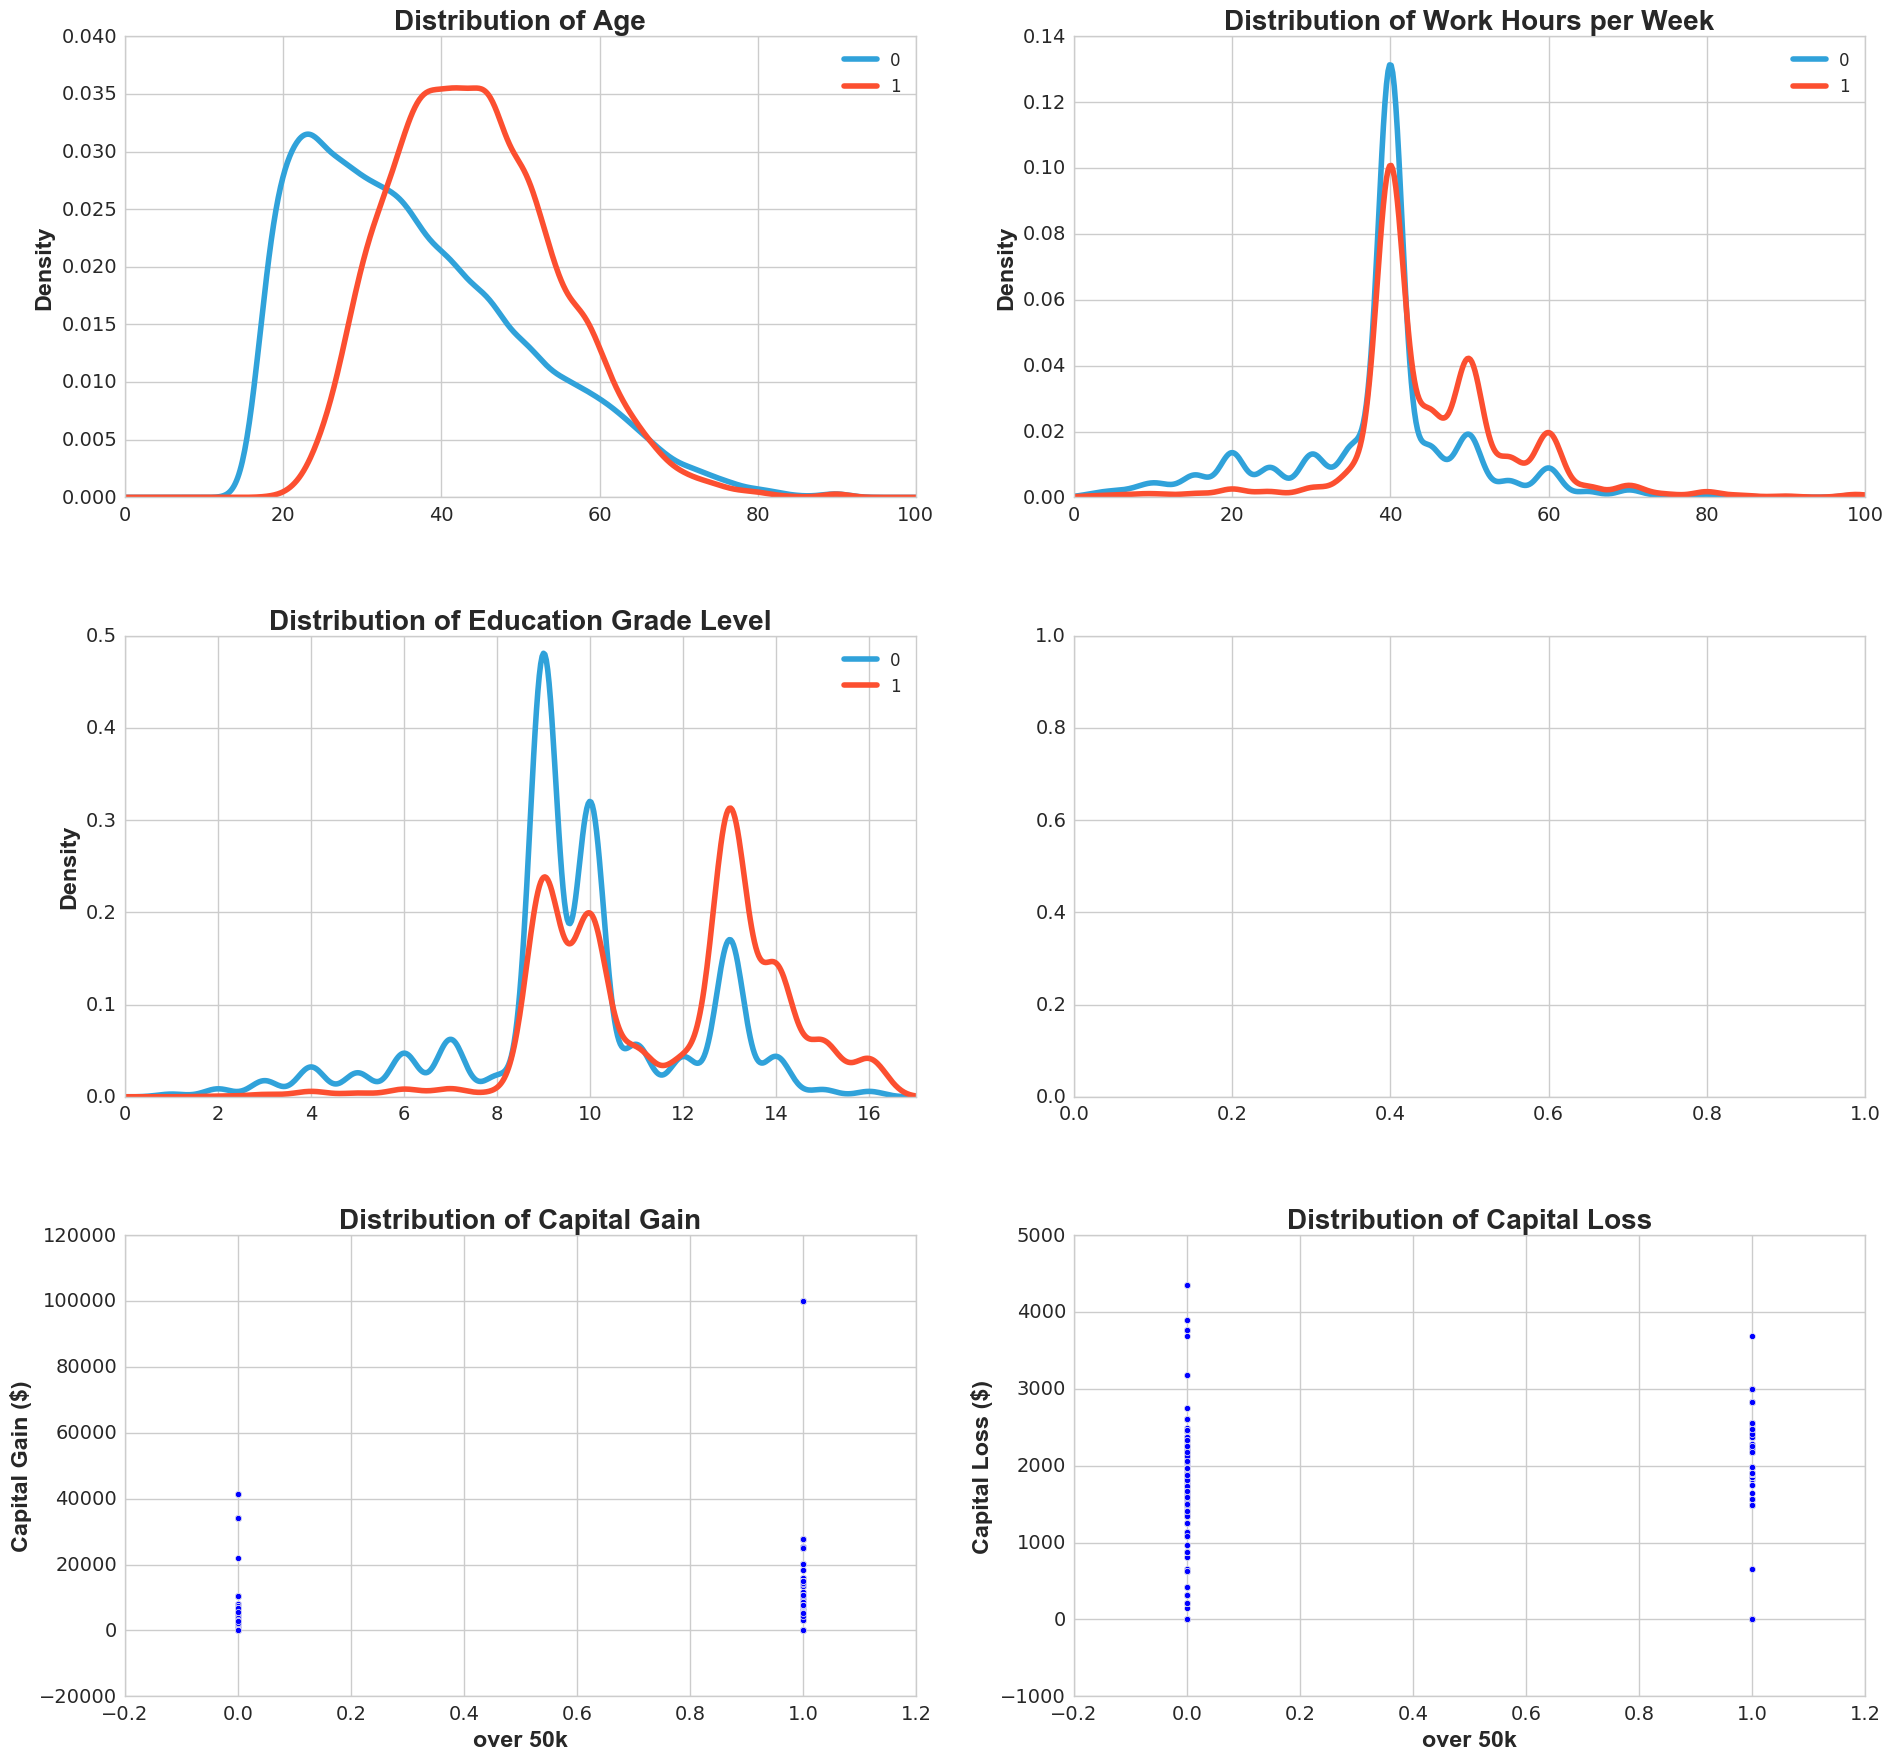

In [327]:
fig, axes = plt.subplots(nrows =3, ncols = 2)
fig.subplots_adjust(hspace = .3)

ax = data.groupby('over_50k')['age'].plot(kind = 'kde', ax = axes[0,0], xlim = (0, 100), legend = True, title = 'Distribution of Age', figsize = (20,20));
ax = data.groupby('over_50k')['hours_week'].plot(kind = 'kde', ax = axes[0,1], xlim=(0, 100), legend = True, title = 'Distribution of Work Hours per Week'); 
ax = data.groupby('over_50k')['education_num'].plot(kind = 'kde', ax = axes[1,0], xlim=(0,17), legend = True, title = 'Distribution of Education Grade Level');
ax = data.plot(kind = 'scatter', x = 'over_50k', y = 'capital_gain', ax = axes[2,0], title = 'Distribution of Capital Gain'); ax.set_xlabel('over 50k'); ax.set_ylabel('Capital Gain ($)');
ax = data.plot(kind = 'scatter', x = 'over_50k', y = 'capital_loss', ax = axes[2,1], title = 'Distribution of Capital Loss'); ax.set_xlabel('over 50k'); ax.set_ylabel('Capital Loss ($)');

In general, you see a trend that those who earned over 50k had distributions that were more left-skewed (heavier on the right-side). They were older in age, worked more hours per week, had higher education, had more capital gain, and even more capital loss.   

**Age**: Those who earned over 50k were older, around 40-50 and had more variance, whereas those who earned less than 50k were younger, around 20-40. However, after age 64, there is a higher proportion of people who are less than 50k. Perhaps the people who have earned more than 50k are going into retirement and are no longer earning income. 

**Work Hours per Week**: As people put in more hours of work per week, they experienced a higher proportion of earning over $50k. This confirms intuition because more work equates to more pay! 

**Education Grade Level**: The more educated, the higher your earnings. The over 50k groups' spikes are higher for every level higher than level 12. There are smaller proportions of people who are less educated for all grade levels 0 to 10. 

**Capital Gain**: I found this to be the best representation of the the distribution over two histograms, density estimations, or boxplots. The highest concentrations of capital gains is higher for over 50k than for under 50k. 

**Capital Loss**: Interestingly, the over 50k group also had more capital loss, perhaps because as they take more risks for capital gain, they are more prone to capital loss. 

For Capital Gain, there are 244 people who have a capital gain of $99,999, which are clear outliers even amongst those who earned over 50k. Even if we take these people out of consideration, we see that there is a significantly different average of capital gain for those who had over 50k and those who did not. 

In [356]:
# Means of capital gain for over 50k and under 50k, after taking out those who earned $99,999
data[data['capital_gain'] != 99999].groupby('over_50k')['capital_gain'].mean()

over_50k
0     147.010308
1    1996.145853
Name: capital_gain, dtype: float64

In [357]:
# Means of capital loss for over 50k and under 50k
data.groupby('over_50k')['capital_loss'].mean()

over_50k
0     54.151931
1    193.528964
Name: capital_loss, dtype: float64

### <a id="4b"></a> 4b. Impact of Employer, Education, Marriage
We will see the effect of employer, education, and marriage on whether you earn 50k or not. We do this by examining the proportion of people who earn over 50k over these categories. We are able to obtain proportions by taking the weighted average of 1s and 0s. The observations in this section will confirm the findings in section 4a that more education and being married lends you a better chance to be in the higher earning bracket.

Let's first examine Employers. The code below looks at the Employer-related variables in workclass and occupations. 

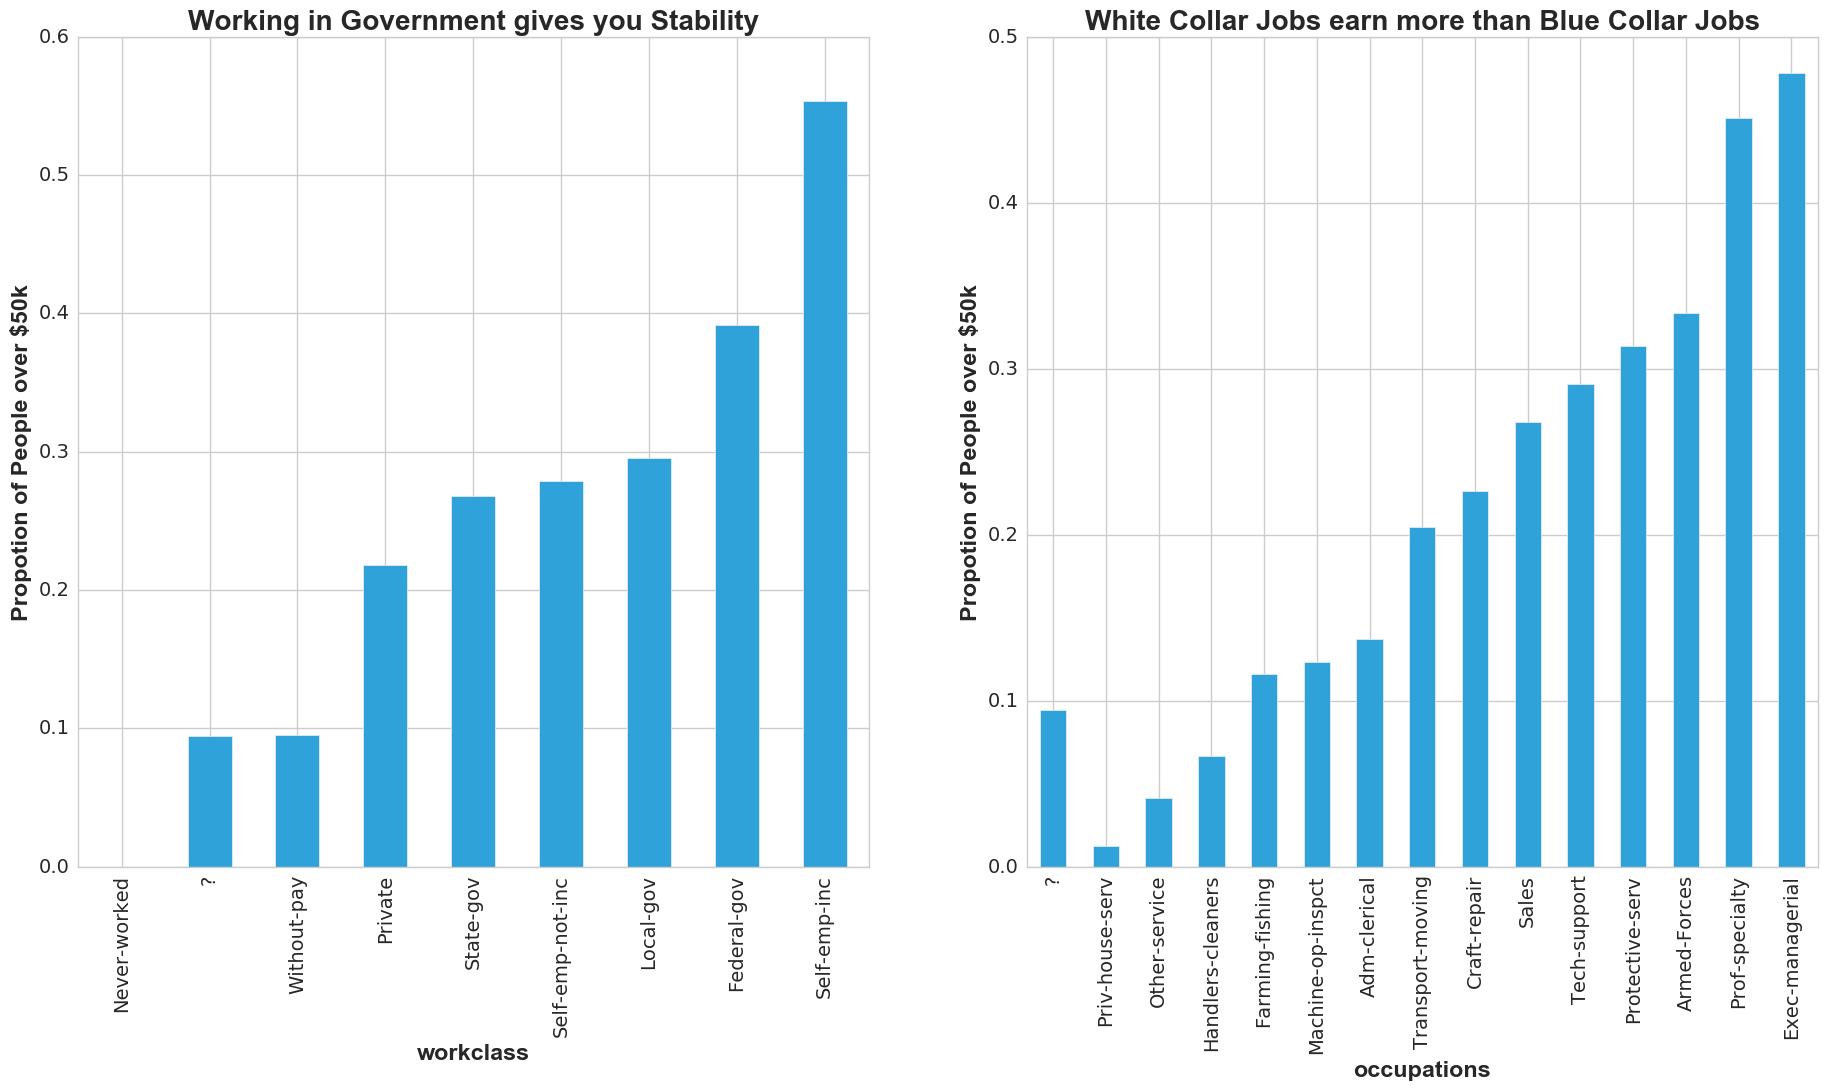

In [441]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (20,10))
ax1.set_ylabel('Propotion of People over $50k')
ax2.set_ylabel('Propotion of People over $50k')

data.groupby('workclass')['over_50k'].mean().sort_values().plot(kind = 'bar', ax = ax1, title = 'Working in Government gives you Stability');

new_index = ['?', 'Priv-house-serv', 'Other-service', 'Handlers-cleaners','Farming-fishing', 'Machine-op-inspct','Adm-clerical','Transport-moving', 'Craft-repair', 'Sales', 'Tech-support','Protective-serv', 'Armed-Forces', 'Prof-specialty', 'Exec-managerial']
data.groupby('occupations')['over_50k'].mean().reindex(new_index).plot(kind = 'bar', ax = ax2, title = 'White Collar Jobs earn more than Blue Collar Jobs');

1st Graph: Although the Self employed group who ran their own business had the highest proportion of earning over 50k, working in a federal, local, or state government ranked high and owned the bulk of the middle. The federal government has more percentage of people with salaries over $50k than do local and state governments.

2nd Graph: Blue collar occupations such as handlers-cleaners, farming-fishing, etc where work involved more physical labor had lower proportions of people earning over $50k. Serving in the military also helped earn an income over 50k, as we see a high proportion of those in armed-forces and protective services earning over 50k.

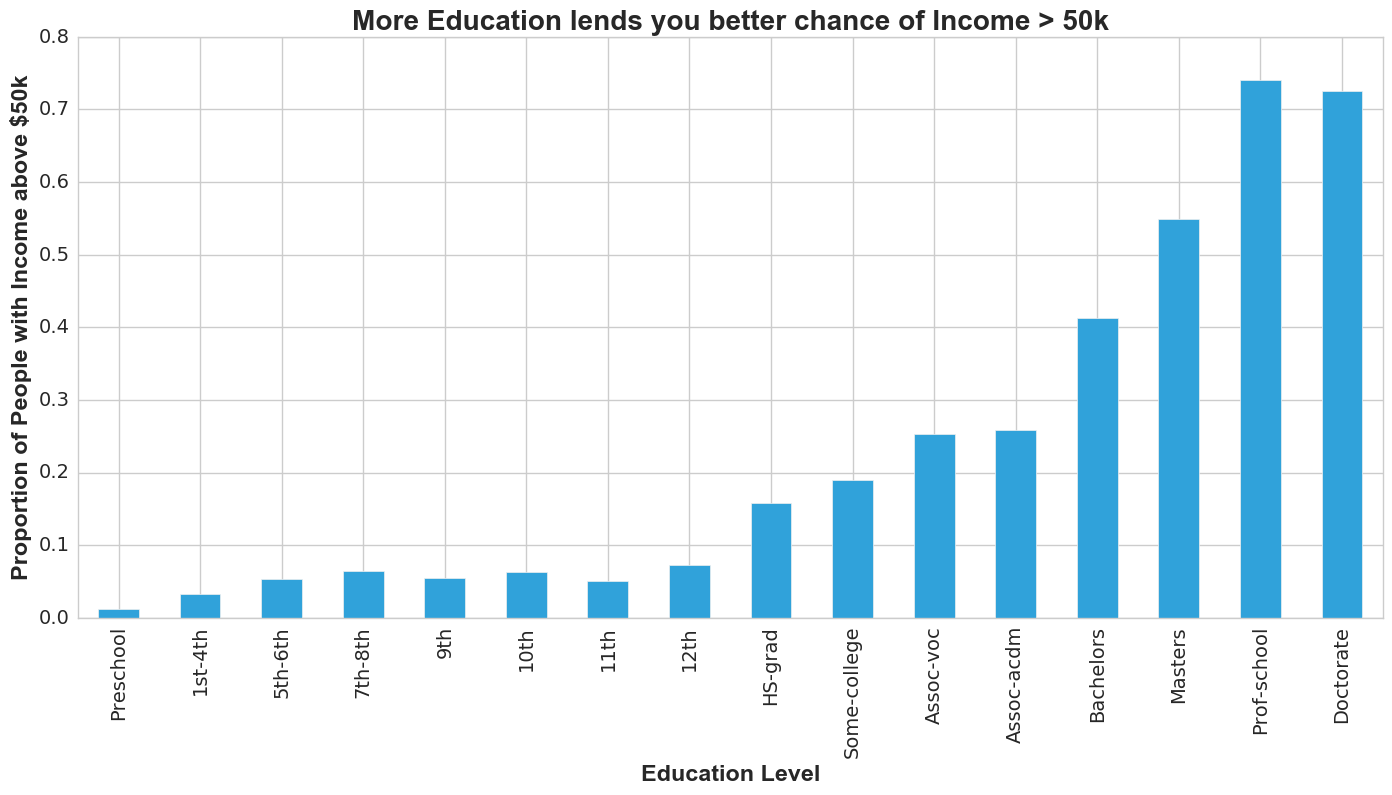

In [403]:
a = data.groupby('education_level')['over_50k'].mean()
new_index= ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college',
        'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school','Doctorate']
a.reindex(new_index).plot(kind = 'bar');
plt.title('More Education lends you better chance of Income > 50k');
plt.ylabel('Proportion of People with Income above $50k');
plt.xlabel('Education Level');

Whereas only about 1% of those who had pre-school only were earning over 50k, more than 70% of professional schools and doctorates were earning over 50k. That is a 1:70 odds! The general trend is that the more education you have, the higher your likelihood is of earning over 50k. The biggest jumps occur between 12th grade and HS graduate, between HS graduate and Bachelors, between Bachelors and Masters, and between Masters and Professional schools. So, with each level of education, it is critical that one actually completes the degree to obtain the higher degree.

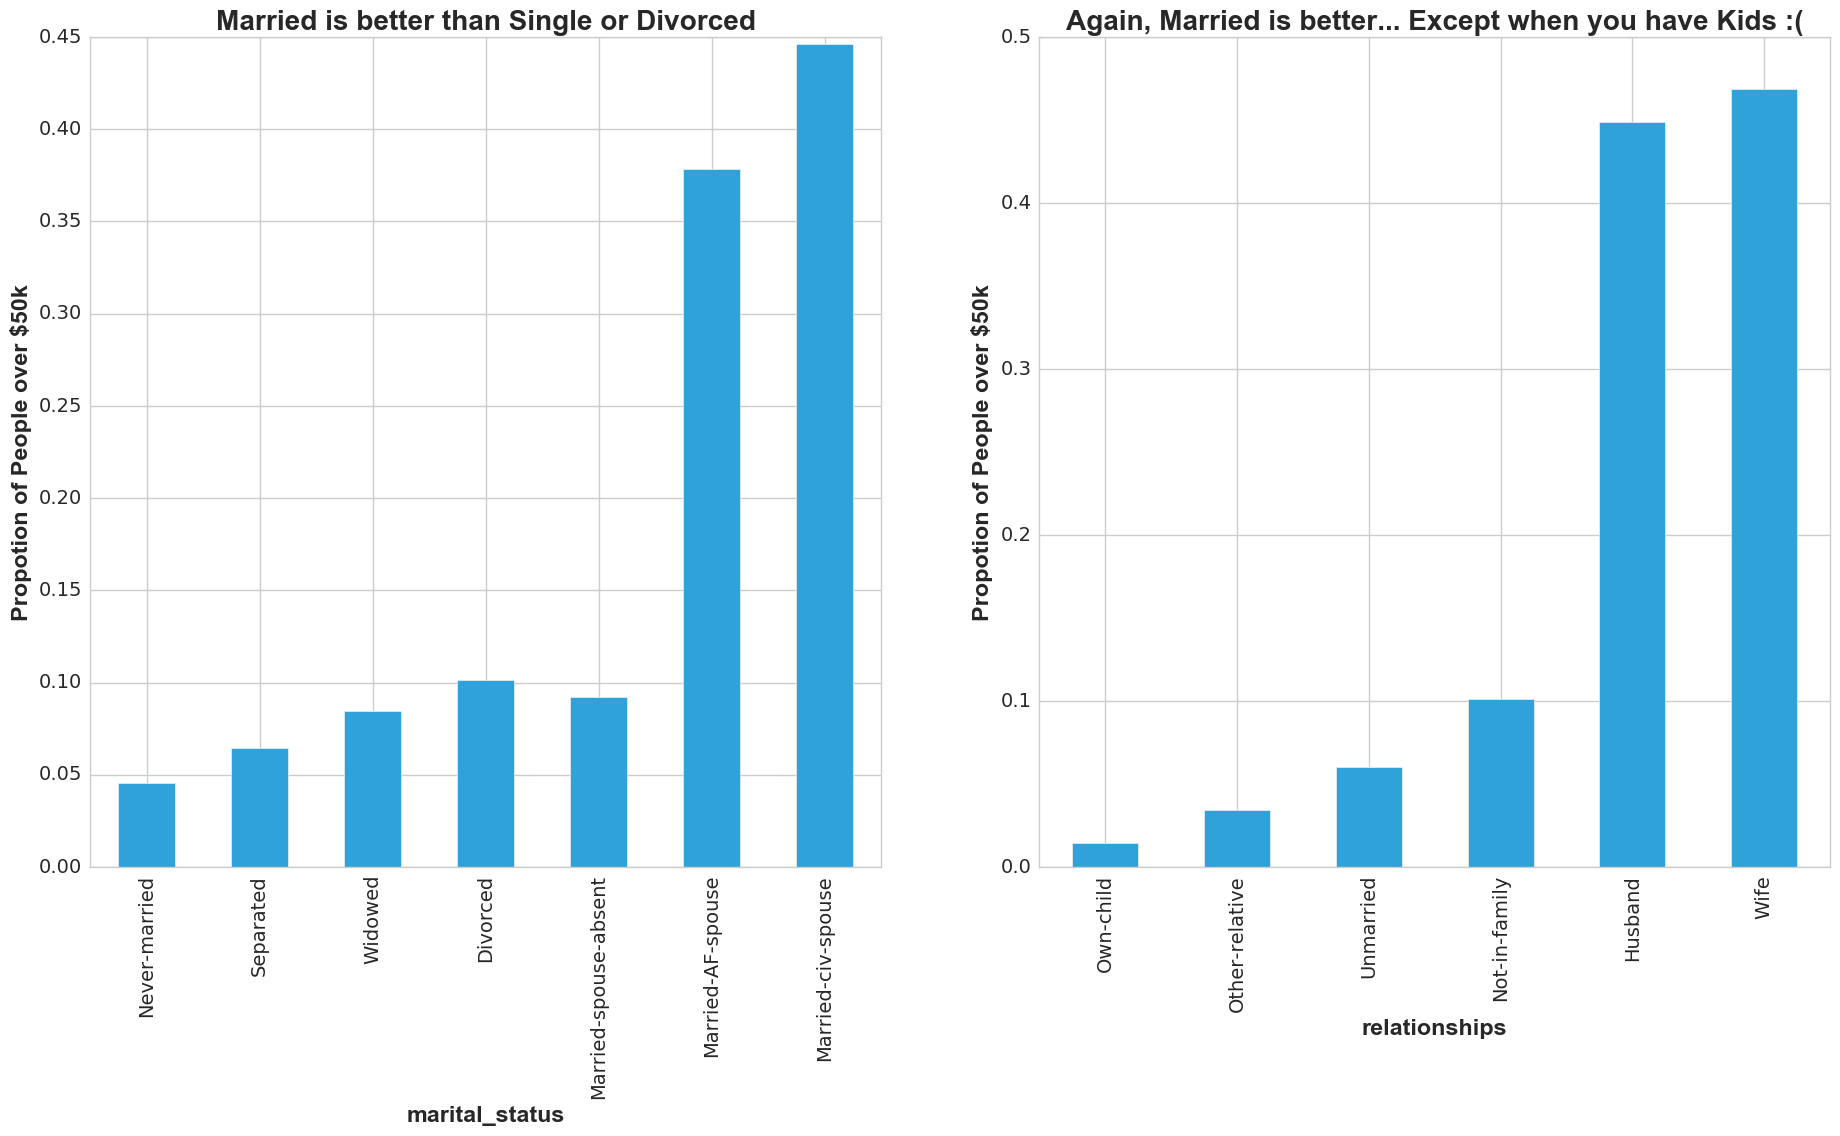

In [437]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (20,10))
ax1.set_ylabel('Propotion of People over $50k'); ax1.set_xlabel('Marriage Status');
ax2.set_ylabel('Propotion of People over $50k')

new_index = ['Never-married', 'Separated', 'Widowed', 'Divorced','Married-spouse-absent', 'Married-AF-spouse','Married-civ-spouse']
data.groupby('marital_status')['over_50k'].mean().reindex(new_index).plot(kind = 'bar', ax = ax1, title = 'Married is better than Single or Divorced');

new_index = ['Own-child', 'Other-relative', 'Unmarried', 'Not-in-family','Husband', 'Wife']
data.groupby('relationships')['over_50k'].mean().reindex(new_index).plot(kind = 'bar', ax = ax2, title = 'Again, Married is better... Except when you have Kids :(');

Graph 1: Married and being together with a partner lended a much higher likelihood of earning over 50k compared to being single, whether that is through being divorced, widowed, or not never married.

Graph 2: The same conclusions can be drawn as from Graph 1, except one oddity that owning a child meant a very low likelihood of earning over 50k. That is a very interesting result. Therefore, I decided to investigate this matter, and found that child owners are more likely to be younger population. As we found above, being younger correlated with earning less than 50k, so age was the missing link here.

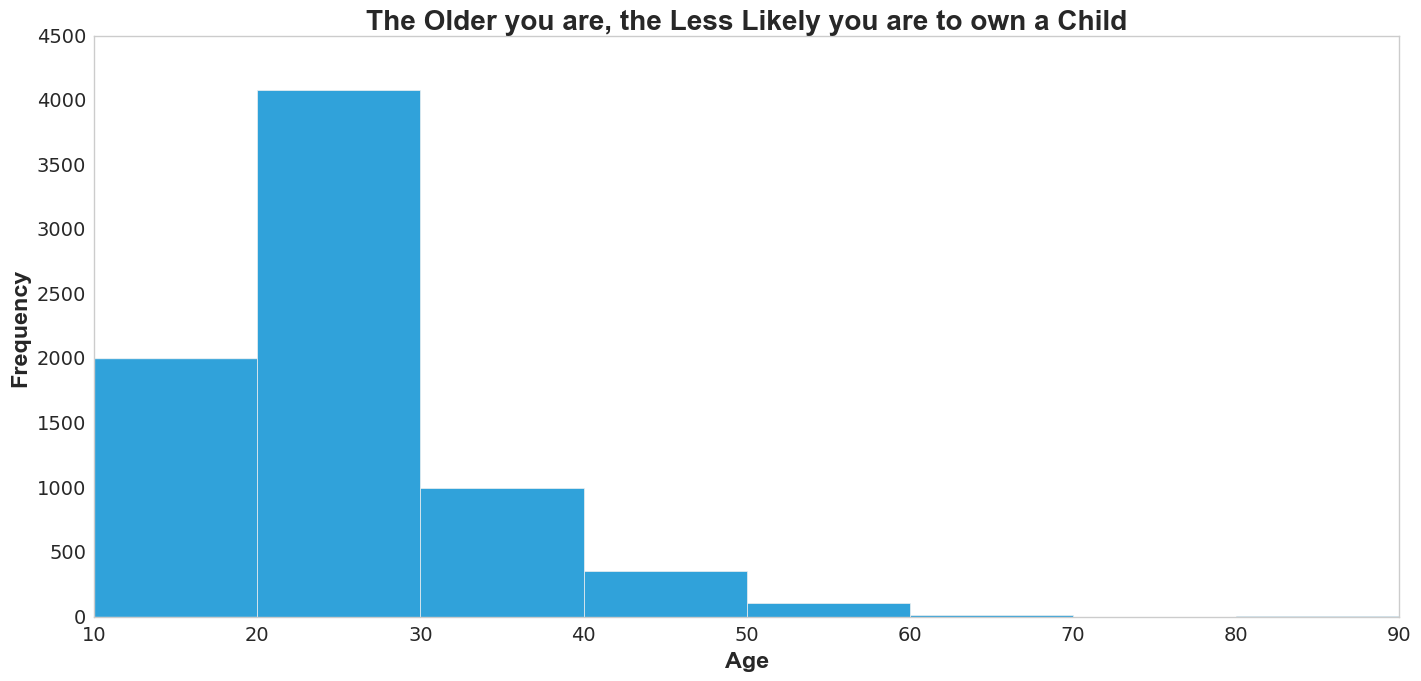

In [560]:
ax = data[data['relationships'] == 'Own-child']['age'].hist(bins = range(10,100,10), grid = None);
ax.set_title('The Older you are, the Less Likely you are to own a Child');
ax.set_xlabel('Age');
ax.set_ylabel('Frequency');

We have explored our data thoroughly and have a better understanding of what factors are important. It is time to build model to predict whether a person earned over 50k. We will do just that in the **[next section](Part 2. Model Building.ipynb)**. Hope you enjoyed the exploratory analysis! 